In [36]:
!pip install gtsam

In [0]:
import gtsam
from pathlib import Path
import numpy as np
from gtsam.utils.plot import plot_pose3
import math
import matplotlib.pyplot as plt
import argparse
from mpl_toolkits.mplot3d import Axes3D
# from measurements_reader import MARSMeasurementsReader

In [0]:
NANOSECONDS_IN_SECOND = 10**9

class MARSMeasurementsReader:
    """
    Reads measurements coming from the 'MARS logger' app.
    Currently, doesn't include images ('movie.mp4').
    """
    def __init__(self, path):
        """
        path:
            pathlib.Path or str
            A directory with 'frame_timestamps.txt', 'gyro_accel.csv', 'movie_metadata.csv', 'movie.mp4'.
        """
        path = Path(path)

        ##############################       Read IMU data       ##############################

        dtype = np.dtype([
            ('time', np.int64),
            ('Wx', np.float64),
            ('Wy', np.float64),
            ('Wz', np.float64),
            ('Ax', np.float64),
            ('Ay', np.float64),
            ('Az', np.float64),
        ])
        IMU_data = np.loadtxt(path / "gyro_accel.csv", dtype=dtype, delimiter=',', skiprows=1)

        # Time in nanoseconds
        self.timestamps_IMU = IMU_data['time']
        # Acceleration along x,y,z (in body frame) in m/s^2
        ax = np.asarray(IMU_data['Ax']).reshape(len(IMU_data), 1)
        ay = np.asarray(IMU_data['Ay']).reshape(len(IMU_data), 1)
        az = np.asarray(IMU_data['Az']).reshape(len(IMU_data), 1)
        conc = np.concatenate((ax, ay,az), axis=1)
        self.accelerometer = conc
        # self.accelerometer  = IMU_data[['Ax', 'Ay', 'Az']].view(dtype=np.float64).reshape(len(IMU_data), 3)
        # Angular velocity around x,y,z (in body frame) in rad/s
        # self.gyroscope      = IMU_data[['Wx', 'Wy', 'Wz']].reshape(len(IMU_data), 3)
        wx = np.asarray(IMU_data['Wx']).reshape(len(IMU_data), 1)
        wy = np.asarray(IMU_data['Wy']).reshape(len(IMU_data), 1)
        wz = np.asarray(IMU_data['Wz']).reshape(len(IMU_data), 1)
        concw = np.concatenate((wx, wy, wz), axis=1)
        self.gyroscope = concw
        self.imu_measurements = np.concatenate((self.accelerometer, self.gyroscope), axis=1)
        ##############################     Read image metadata     ##############################

        dtype = np.dtype([
            ('time', np.int64),
            ('fx', np.float64),
            ('fy', np.float64),
            ('focal_length', np.float64),
            ('focus_distance', np.float64),
        ])
        camera_data = np.loadtxt(path / "movie_metadata.csv", dtype=dtype, delimiter=',', skiprows=1, usecols=(0,1,2,8,9))

        # Time in nanoseconds (consistent with `self.timestamps_IMU`)
        self.timestamps_camera = camera_data['time']

    def get_dt_IMU(self, i):
        """
        i:
            int
            Index of the IMU measurement in `self.timestamps_IMU`.

        return:
            float
            Time in seconds between i-th and (i+1)-th IMU measurements
        """
        if i > len(self.timestamps_IMU) - 2 or i < 0:
            return 1e-16
        else:
            return (self.timestamps_IMU[i+1] - self.timestamps_IMU[i]) / NANOSECONDS_IN_SECOND


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/robotics/'

In [0]:
def initial_estimation(accelerations):
    acc_avg = np.squeeze(np.mean(accelerations, axis=0))
    acc_avg = acc_avg/np.linalg.norm(acc_avg, ord=2)
    gravity_vec = np.zeros_like(acc_avg)
    gravity_vec[2] = 1
    v = np.cross(acc_avg, gravity_vec)
    s = np.linalg.norm(v, ord=2)
    c = np.dot(acc_avg, gravity_vec)
    V = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    R = np.eye(3) + V + V**2*((1-c)/s**2)
    init_att = gtsam.Rot3(R)
    print(init_att)
    init_pose = gtsam.Pose3(init_att, gtsam.Point3())
    return init_pose

In [71]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--path', type=str, default = 'C:/Users/Polinka/PycharmProjects/sample_data')
# args = parser.parse_args()
reader = MARSMeasurementsReader(path)
accelerometer = reader.accelerometer
gyroscope = reader.gyroscope
imu_m = reader.imu_measurements
# imu_measurements, _, _, true_poses = np.load('circle_gold.npy',allow_pickle=True)
##############################   Algorithm parameters   ############################
params = argparse.Namespace()
    # Time step length.
    # In real world, it will be different at each measurement,
    # and you'll have to take dtᵢ from data.
params.dt = [reader.get_dt_IMU(i) for i in range(len(reader.timestamps_IMU))]
    # params.dt = 1e-2
        
    # IMU bias
params.accelerometer_bias = np.array([0, 0, 0])
params.gyroscope_bias = np.array([0, 0, 0])
params.IMU_bias = gtsam.imuBias_ConstantBias(params.accelerometer_bias, params.gyroscope_bias)
   
    # 'circle_gold.npy' simulates a loop with forward velocity 2 m/s,
    # while pitching up with angular velocity 30 degrees/sec.
params.initial_velocity = np.array([0, 0, 0])
params.initial_angular_vel = np.array([0, -math.radians(30), 0]) # not used here
params.initial_pose = initial_estimation(accelerometer)
#params.initial_pose = gtsam.Pose3()
params.initial_state = gtsam.NavState(params.initial_pose, params.initial_velocity)

    # IMU preintegration algorithm parameters
    # "U" means "Z axis points up"; "MakeSharedD" would mean "Z axis points along the gravity" 
preintegration_params = gtsam.PreintegrationParams.MakeSharedU(9.81) # 10 is the gravity force
    # Realistic noise parameters
kGyroSigma = math.radians(0.5) / 60  # 0.5 degree ARW
kAccelSigma = 0.1 / 60  # 10 cm VRW
preintegration_params.setGyroscopeCovariance(kGyroSigma ** 2 * np.identity(3, np.float))
preintegration_params.setAccelerometerCovariance(kAccelSigma ** 2 * np.identity(3, np.float))
preintegration_params.setIntegrationCovariance(0.0000001 ** 2 * np.identity(3, np.float))
params.preintegration_params = preintegration_params
    # The stateful class that is responsible for preintegration
current_preintegrated_IMU = gtsam.PreintegratedImuMeasurements(params.preintegration_params, params.IMU_bias)

    # The certainty (covariance) of the initial position estimate
    # "Isotropic" means diagonal with equal sigmas
params.initial_pose_covariance = gtsam.noiseModel_Isotropic.Sigma(6, 0.1)
params.initial_velocity_covariance = gtsam.noiseModel_Isotropic.Sigma(3, 0.1)

    ###############################    Build the factor graph   ####################################
    
factor_graph = gtsam.NonlinearFactorGraph()
    # A technical hack for defining variable names in GTSAM python bindings
def symbol(letter, index): return int(gtsam.symbol(ord(letter), index))

    # Add a prior factor on the initial position
factor_graph.push_back(gtsam.PriorFactorPose3(symbol('x', 0), params.initial_pose, params.initial_pose_covariance))
factor_graph.push_back(gtsam.PriorFactorVector(symbol('v', 0), params.initial_velocity, params.initial_velocity_covariance))
#factor_graph.push_back(gtsam.PriorFactorVector(symbol('v', 0), params.initial_velocity, params.initial_velocity_covariance))
    # Add IMU factors (or "motion model"/"transition" factors).
    # Ideally, we would add factors between every pair (xᵢ₋₁, xᵢ). But, to save computations,
    # we will add factors between pairs (x₀, xₖ), (xₖ, x₂ₖ) etc., and as an IMU "measurement"
    # between e.g. x₀ and xₖ we will use combined (pre-integrated) measurements `0, 1, ..., k-1`.
    # Below, `k == PREINTEGRATE_EVERY_STEPS`.
PREINTEGRATE_EVERY_STEPS = 25

    # For code generalization, create pairs (0, k), (k, 2k), (2k, 3k), ..., (mk, N-1)
preintegration_steps = list(range(0, len(imu_m), PREINTEGRATE_EVERY_STEPS))
if preintegration_steps[-1] != len(imu_m) - 1: # don't miss the last measurements
  preintegration_steps.append(len(imu_m) - 1)
    # An iterator over those pairs
imu_factor_pairs = zip(preintegration_steps[:-1], preintegration_steps[1:])
current_imu_factor_pair = next(imu_factor_pairs)

    # Clear the accumulated value
current_preintegrated_IMU.resetIntegration()

for i, imu_measurement in enumerate(imu_m):
    measured_acceleration, measured_angular_vel = imu_m[:3], imu_m[3:]

    if i == current_imu_factor_pair[1]:
            # Add IMU factor
        factor = gtsam.ImuFactor(
        symbol('x', current_imu_factor_pair[0]),
        symbol('v', current_imu_factor_pair[0]),
        symbol('x', current_imu_factor_pair[1]),
        symbol('v', current_imu_factor_pair[1]),
        symbol('b', 0),
        current_preintegrated_IMU)
        factor_graph.push_back(factor)
            
            # Start accumulating from scratch
        current_preintegrated_IMU.resetIntegration()

            # Get the next pair of indices
        try:
            current_imu_factor_pair = next(imu_factor_pairs)
        except StopIteration:
            assert i == len(imu_m) - 1

    # Accumulate the current measurement
    current_preintegrated_IMU.integrateMeasurement(measured_acceleration, measured_angular_vel, params.dt[i])

    ############################# Specify initial values for optimization #################################

    # The optimization will start from these initial values of our target variables:
    initial_values = gtsam.Values()

    # The initial value for IMU bias
    initial_values.insert(symbol('b', 0), params.IMU_bias)


    # The initial values for coordinates (x) and velocities (v), estimated by IMU preintegration.
    # Note that our variables are only for those steps that have been chosen into `preintegration_steps`.
    preintegration_steps_set = set(preintegration_steps)
    # Clear the accumulated value from the previous code section
    current_preintegrated_IMU.resetIntegration()

    for i, imu_measurement in enumerate(imu_m):
        if i in preintegration_steps_set:
            predicted_nav_state = current_preintegrated_IMU.predict(params.initial_state, params.IMU_bias)
            initial_values.insert(symbol('x', i), predicted_nav_state.pose())
            initial_values.insert(symbol('v', i), predicted_nav_state.velocity())

        current_preintegrated_IMU.integrateMeasurement(imu_m[i, :3], imu_m[i, 3:], params.dt[i])


[
 	         1          0  0.0309435;
    	         0          1  -0.191534;
    	-0.0300037   0.238275          1
  ]



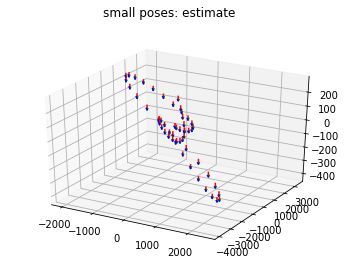

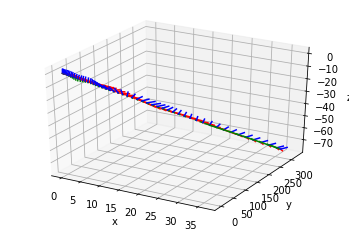

In [72]:
 ###############################    Optimize the factor graph   ####################################

# Use the Levenberg-Marquardt algorithm
optimization_params = gtsam.LevenbergMarquardtParams()
optimization_params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(factor_graph, initial_values, optimization_params)
optimization_result = optimizer.optimize()


    ###############################        Plot the solution       ####################################

for i in preintegration_steps:
     # Ground truth pose
    # plot_pose3(1, gtsam.Pose3(true_poses[i]), 0.3)
    # Estimated pose
    plot_pose3(1, optimization_result.atPose3(symbol('x', i)), 30)
    plot_pose3(2, initial_values.atPose3(symbol('x', i)), 3)
#fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
#ax.set_xlim3d(-100, 100)
#ax.set_ylim3d(-100, 100)
#ax.set_zlim3d(-100, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.figure(1).suptitle("small poses: estimate")

plt.ioff()
plt.show()

In [23]:
optimization_result.atPose3(symbol('x', 0))

R:
[
 	1 0 0;
    	0 1 0;
    	0 0 1
  ]
[0, 0, 0]';